In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
# from read_data import load_df
import numpy as np
from preprocessing import PrepareData
from jupyterthemes import jtplot
jtplot.style()
from keras.callbacks import ReduceLROnPlateau
from preprocessing import PrepareData

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import datetime

from keras.callbacks import TensorBoard

In [11]:
def convert_to_price(sales, predict_results):
    max_s = sales.SalePrice.max()
    min_s = sales.SalePrice.min()
    predicted_p = predict_results*(max_s - min_s) + min_s
    return predicted_p

In [12]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [13]:
def split_data(x, y, ratio):
    n = int(ratio*x.shape[0])
    return (x[:n, :], x[n:, :], y[:n], y[n:])

In [14]:
def normalize_price(sale_price):
    # return normalized price
    width = sale_price.max() - sale_price.min()
    return (sale_price - sale_price.min())/width

In [69]:
def train_model(train_x, train_y, batch_size, test_x=None, test_y=None):
    model = Sequential()
#     model.add(LSTM(50, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
#     model.add(Dropout(0.2))
    model.add(LSTM(10, input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(100))
    model.add(Dropout(0.2))
    model.add(Dense(200))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)
    tf_board = TensorBoard(log_dir='./logs/log_{}'.format(datetime.datetime.now().strftime("%H%M")), histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
    if not test_x is None and not test_y is None:
        kwargs = {
            "validation_data": (test_x, test_y),
        }
    else:
        kwargs = {}
    history = model.fit(train_x, train_y, epochs=80, batch_size=batch_size, verbose=2, shuffle=True, callbacks=[reduce_lr, tf_board], **kwargs)
    return model, history

In [81]:
# drop_cols = ['Id'] + ppd.sales_attrs
ppd = PrepareData()
df , sale_price = ppd.get_train_data(time_series=True, drop_cols = ['Id'] + ppd.sales_attrs)
# df = df.sort_values('YearBuilt')
df.drop("SalePrice", axis=1, inplace=True)

In [71]:
from random import shuffle
attrs = df.columns.tolist()
shuffle(attrs)
## shuttle colum orders
df = df[attrs]

In [86]:
batch_size = 10
n_shift = 5
reframed = series_to_supervised(df.values, n_shift)
values = reframed.values
# values = df.values

In [87]:
# shift the sale price by the number of days shifted
sale_price_shifted = normalize_price(sale_price[n_shift:])

train_x, test_x, train_y, test_y = split_data(values, sale_price_shifted, 0.8)

# reshape to [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) 

model, history = train_model(train_x, train_y, batch_size, test_x, test_y)
# make a prediction
pred_train = model.predict(train_x)
print 'RMSE (Training Data):', mean_squared_error(train_y , pred_train)
pred_test = model.predict(test_x)
print 'RMSE (Testin Data):', mean_squared_error(test_y , pred_test)

with open('results.txt', 'a') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    f.write('RMSE (Training Data):' + str(mean_squared_error(train_y , pred_train)) + "\n")
    f.write('RMSE (Testin Data):' + str(mean_squared_error(test_y , pred_test))+ "\n\n" )

((1164, 1, 1380), (1164, 1), (291, 1, 1380), (291, 1))
Train on 1164 samples, validate on 291 samples
Epoch 1/80
 - 2s - loss: 0.0105 - val_loss: 0.0054
Epoch 2/80
 - 1s - loss: 0.0051 - val_loss: 0.0035
Epoch 3/80
 - 1s - loss: 0.0036 - val_loss: 0.0032
Epoch 4/80
 - 1s - loss: 0.0033 - val_loss: 0.0029
Epoch 5/80
 - 1s - loss: 0.0026 - val_loss: 0.0035
Epoch 6/80
 - 1s - loss: 0.0020 - val_loss: 0.0031
Epoch 7/80
 - 1s - loss: 0.0020 - val_loss: 0.0031
Epoch 8/80
 - 1s - loss: 0.0022 - val_loss: 0.0026
Epoch 9/80
 - 1s - loss: 0.0018 - val_loss: 0.0031
Epoch 10/80
 - 1s - loss: 0.0017 - val_loss: 0.0022
Epoch 11/80
 - 1s - loss: 0.0016 - val_loss: 0.0023
Epoch 12/80
 - 1s - loss: 0.0013 - val_loss: 0.0024
Epoch 13/80
 - 1s - loss: 0.0014 - val_loss: 0.0023
Epoch 14/80
 - 1s - loss: 0.0013 - val_loss: 0.0031
Epoch 15/80
 - 1s - loss: 0.0013 - val_loss: 0.0024
Epoch 16/80
 - 1s - loss: 0.0016 - val_loss: 0.0029
Epoch 17/80
 - 1s - loss: 0.0014 - val_loss: 0.0029
Epoch 18/80
 - 1s - los

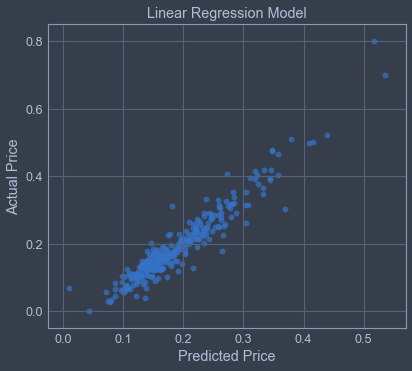

In [68]:
plt.scatter(pred_test, test_y, alpha=.75,
            color='b') #alpha helps to show overlapping data
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')
plt.show()

In [36]:
test_df, test_ids = ppd.get_test_data(time_series=True)
test_data = test_df.values.reshape(test_df.shape[0], 1, test_df.shape[1])

In [ ]:
df.head(n_shift)

In [ ]:
test_df_padded = pd.concat([df.head(n_shift), test_df], ignore_index=True)

In [ ]:
test_reframed = series_to_supervised(test_df_padded.values, n_shift)

In [ ]:
test_reframed_data = test_reframed.values.reshape(test_reframed.shape[0], 1, test_reframed.shape[1])

In [ ]:
df.sort_values('YearBuilt', inplace=True)

In [ ]:
model2, history2 = train_model(train_x, train_y, batch_size)

In [ ]:
predict_results = model.predict(test_reframed_data)
price = convert_to_price(sale_price, predict_results)
test_ids['SalePrice'] = price
test_ids.to_csv("submission/submission_lstm_{}.csv".format(datetime.datetime.now().strftime("%Y-%m-%d_%H_%M")), index=False)

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [ ]:
train_x, test_x, train_y, test_y = split_data(values, sale_price_shifted, 0.8)